---
---

# The Right Quarterback for Your NFL Franchise: The Final Notebook
---
---

<div class="alert alert-block alert-warning">
Adapt the headline in the cell above!
</div>

<div class="alert alert-block alert-warning">

Present a short summary of the pitch!

(Add up to 5 bullet points in the cell below)
</div>

- **Business Need:** NFL teams spend millions of dollars on their quarterbacks: wrong decisions can cost sporting success and lead to financial trouble, so objective and data-driven evaluation would support the dcision-making process

- **Dataset:** 2001-2023 passer statistics (> 2 000 player-season entries, 27 features) sourced from Pro Football Reference via Kaggle

- **Reducing the Data:** filter for passers with ≥ 224 pass attempts per season to ensure only QBs are kept, as well as improving the possibilities for interpretability later on

- **Analytical Approach:** explore the data with multivariate statistics, reduce dimensionality with PCA, then use different clustering algorithms to search for quarterback performance archetypes

- **Expected Value:** quickly show coaches and GMs how a current or prospective QB compares to clustering groups, helping target scouting, roster planning, and contract negotiations

# Imports and Settings
---
<div class="alert alert-block alert-warning">
Use the following code cell to organize all imports and global settings.
Do not remove the pandas option.
    
(Commented code, in the next cell)
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import seaborn as sns
import scipy.stats
import math
import itertools
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans, OPTICS, AgglomerativeClustering 
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples #, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# make pandas display ALL columns of a dataframe
pd.options.display.max_columns = None

# Task 1 -- The Data

<div class="alert alert-block alert-warning">
Present the origin of the dataset, including e.g.
    
* the source where you got it from (link to the repository),
* the author(s),
* the license,
* the purpose for which it was collected!

(Add bullet points in the cell below)
</div>

- Repository/Download link - Kaggle dataset "NFL Passing Statistics (2001 – 2023)":<br> https://www.kaggle.com/datasets/rishabjadhav/nfl-passing-statistics-2001-2023

- You can download the data on your own, but I also provide it for you in the folder 'data' under the name 'passer_stats_raw_data.csv'

- Author: Rishab Jadhav (Kaggle user), who scraped and consolidated the raw tables

- Primary data source: Pro Football Reference, an online sports statistics archive maintained by Sports Reference LLC

- License: Creative Commons CC-BY-4.0 (dataset may be shared/adapted with attribution); Pro Football Reference allows non-commercial use of their tables with attribution

- Original purpose: collect data for a clean dataframe of NFL passer-season entires since 2001 to predict the NFL MVP winner in 2024 (for this purpose the data was used together with NFL rushing statistics)

## The Raw Data
<div class="alert alert-block alert-warning"> 

Load the data and present a couple of samples. Call the dataset variable __raw_data__.

(Commented code, add cells below)
</div>


In [2]:
# Load the data in a dataframe and show first 5 entries
raw_data = pd.read_csv("data/passer_stats_raw_data.csv", header=0) # 'index_col = 0' -> avoid column 'Unnamed: 0', which just is the index
raw_data.head(5)

,Unnamed: 0,Player,Tm,Age,G,GS,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,1D,Lng,Y/A,AY/A,Y/C,Y/G,Rate,Sk,Yds-s,Sk%,NY/A,ANY/A,Year
0,0,Kurt Warner,STL,30,16,16,375,546,68.7,4830,36,6.6,22,4.0,233,65,8.8,8.4,12.9,301.9,101.4,38,233,6.5,7.87,7.41,2001
1,1,Peyton Manning,IND,25,16,16,343,547,62.7,4131,26,4.8,23,4.2,201,86,7.6,6.6,12.0,258.2,84.1,29,232,5.0,6.77,5.88,2001
2,2,Brett Favre,GNB,32,16,16,314,510,61.6,3921,32,6.3,15,2.9,187,67,7.7,7.6,12.5,245.1,94.1,22,151,4.1,7.09,7.02,2001
3,3,Aaron Brooks,NOR,25,16,16,312,558,55.9,3832,26,4.7,22,3.9,182,63,6.9,6.0,12.3,239.5,76.4,50,330,8.2,5.76,4.99,2001
4,4,Rich Gannon,OAK,36,16,16,361,549,65.8,3828,27,4.9,9,1.6,195,49,7.0,7.2,10.6,239.3,95.5,27,155,4.7,6.38,6.61,2001


<div class="alert alert-block alert-warning"> 
Explain the dataset with all its features.
    
* The features should be described in the following table. The range is the set of possible values that a feature can take, e.g. "red, green, blue", "$\mathbb{R}$", "$1,2,...,12$".
* You may describe each feature individually or groups of features, if many features are similar (whatever is easier to explain.)

(Fill in the table, add bullet points in the next cell)
</div>

| Feature | Range  | Explanation |
|---------|--------|-------------|
|$Unnamed\colon\,0$ |$\mathbb{N_0}$ |Index (row number, starting at 0) |
|$Player$  |Any Name as String |Player's name |
|$Tm$  |'STL', 'IND', 'GNB', 'NOR', 'OAK', 'KAN', 'NYG', 'ARI', 'SFO', 'SDG', 'TAM', 'TEN', 'JAX', 'MIA', 'PHI', 'CIN', 'PIT', 'CLE', 'BAL', 'CAR', 'ATL', 'NWE', 'DEN', 'NYJ', 'MIN', 'DET', 'WAS', 'CHI', 'BUF', 'SEA', 'DAL', 'HOU', '2TM', 'LAR', 'LAC', 'LVR', '3TM' (xTM meaning the player was under contract for x teams that year) |Player's team during that season |
|$Age$  |$\mathbb{N_0}$ (NFL has no minimum age) |Player's age |
|$G$  |1 - 17 |Number of games, in which the player played at some time of the game |
|$GS$  |0 - 17 |Number of games, in which the player started from the beginning of the game |
|$Cmp$  |$\mathbb{N_0}\,(≤Att)$ |Total completed passes (teammate caught the ball) |
|$Att$ |$\mathbb{N}$ |Total pass attempts (does NOT include sacks) |
|$Cmp%$  |0% - 100%   |Percentage of passes completed = $\frac{Cmp}{Att}$ |
|$Yds$ |$\mathbb{Z}$ (negative, if yards were lost after a completed pass) |Total passing yards over all games of this season |
|$TD$ |$\mathbb{N_0}$ |Number of passes that resulted in a touchdown (teammate caught the pass in the endzone or run in after the catch)|
|$TD%$ |0% - 100% |Percentage of touchdown passes = $\frac{TD}{Att}$|
|$Int$ |$\mathbb{N_0}$ |Number of passes intercepted by the opposing team |
|$Int%$ |0% - 100% |Percentage of interception passes = $\frac{Int}{Att}$ |
|$1D$ |$\mathbb{N_0}$ |Number of passes that resulted in a new first down |
|$Lng$ |$\mathbb{Z}$ (negative, if yards were lost after the completed pass) |The longest completed pass (in yards) for that season |
|$Y/A$ |$\mathbb{R}$ (negative, if $Yds$ negative) |Average yards thrown per pass attempt = $\frac{Yds}{Att}$ |
|$AY/A$ |$\mathbb{R}$ (negative, if $Yds$ negative or due to calculation method) |Adjusted average yards thrown per pass attempt = $\frac{Yds\, +\, 20 \cdot TD\, -\, 45 \cdot Int}{Att}$ |
|$Y/C$ |$\mathbb{R}$ (negative, if $Yds$ negative) |Average yards thrown per complete pass = $\frac{Yds}{Cmp}$ |
|$Y/G$ |$\mathbb{R}$ (negative, if $Yds$ negative) |Average yards thrown per game = $\frac{Yds}{G}$ |
|$Rate$ |0.0 - 158.3|Official NFL passer rating (0 = worst, 158.3 = best) |
|$Sk$ |$\mathbb{N_0}$ |Total number of sacks taken by the player |
|$Yds\text{-}s$ |$\mathbb{N_0}$ |Total yards lost due to sacks |
|$Sk%$ |0% - 100% |Sack percentage = $\frac{Sk}{Att\, +\, Sk}$ |
|$NY/A$ |$\mathbb{R}$ (negative, if $Yds$ negative and/or <br> $Yds\text{-}s$ > $Yds$) |Average net yards thrown per pass attempt = $\frac{Yds\, -\, Yds\text{-}s}{Att\, +\, Sk}$ |
|$ANY/A$ |$\mathbb{R}$ (negative, if $Yds$ negative or due to calculation method) |Adjusted average net yards thrown per pass attempt = $\frac{Yds\, +\, 20 \cdot TD\, -\, 45 \cdot Int\, -\, Yds\text{-}s}{Att\, +\, Sk}$|
|$Year$ |2001 - 2023 |Year/Season of the entry |

<div class="alert alert-block alert-warning">
Explain why the dataset is suitable for the pitched task!
    
(Add up 3 bullet points in the cell below)
</div>

- With more than 2000 entries it contains enough records to perform meaningful analyses.
- It provides 27 columns (index column included) of which 25 are numeric, allowing for diverse exploratory analyses as well as retaining enough features after dimensionality reduction.
- Data quality is high, as there are no missing values.

# Task 2 -- Initial Data Analysis

<div class="alert alert-block alert-warning"> 
<b>Initial Data Analysis (IDA)</b>: Present relevant quantities about the data.
    
(Commented Code + bullet points, add cells below)
</div>

In [3]:
# Get shape of the dataset
raw_data.shape

(2350, 27)

$\Rightarrow$ The raw dataset contains 2350 rows and 27 columns

In [4]:
# Get more datailed information, e.g. data types of columns 
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2350 non-null   int64  
 1   Player      2350 non-null   object 
 2   Tm          2350 non-null   object 
 3   Age         2350 non-null   int64  
 4   G           2350 non-null   int64  
 5   GS          2350 non-null   int64  
 6   Cmp         2350 non-null   int64  
 7   Att         2350 non-null   int64  
 8   Cmp%        2350 non-null   float64
 9   Yds         2350 non-null   int64  
 10  TD          2350 non-null   int64  
 11  TD%         2350 non-null   float64
 12  Int         2350 non-null   int64  
 13  Int%        2350 non-null   float64
 14  1D          2350 non-null   int64  
 15  Lng         2350 non-null   int64  
 16  Y/A         2350 non-null   float64
 17  AY/A        2350 non-null   float64
 18  Y/C         2350 non-null   float64
 19  Y/G         2350 non-null  

$\Rightarrow$ As mentioned before, no missing values and 25 numerical features

In [5]:
# Show how many unique values there are in each column 
raw_data.nunique()

Unnamed: 0    2350
Player         715
Tm              37
Age             25
G               17
GS              18
Cmp            406
Att            551
Cmp%           297
Yds           1210
TD              49
TD%            105
Int             30
Int%           108
1D             257
Lng            107
Y/A            191
AY/A           261
Y/C            196
Y/G           1152
Rate           688
Sk              63
Yds-s          334
Sk%            173
NY/A           637
ANY/A          796
Year            23
dtype: int64

# Task 3 -- Preprocessing

<div class="alert alert-block alert-warning"> 
Conduct all steps of Task 3. Call the result "data".
    
(Commented code + bullet points, add cells below)
</div>

Before applying the preprocessing steps, let's define a method to change a column position in a dataframe, which will be used for this task:

In [6]:
def change_col_pos(df, col, col_label, after_col, inplace=False):
    """
    Change the position/index of a column in a dataframe.

    Parameters:
    ----------
    df : DataFrame
        The dataframe that contains the column to change.
    
    col : String
        Current label of the column, which position should be changed.
    
    col_label : String
        New label of the column, which position should be changed. This will be the label for the column at the new position.

    after_col : String
        Label of the column, after which col will be placed. In the modified dataframe col_label (col) is the right neighbor of after_col. 
    
    inplace : Boolean
        If False, return the modified dataframe. Otherwise, do operation in place and return None.
    Returns:
    ----------
    DataFrame
        The modified dataframe with the new position of col with the label 'col_label'.
    """

    new_idx = df.columns.get_loc(f'{after_col}') + 1
    col = df.pop(f'{col}')
    df.insert(new_idx, f'{col_label}', col)
    if not inplace:
        return df

1\. Drop all players with less than 224 pass attempts in the respective season:
- Reason: 14 passes per game over a 16-game season are required to occur on the official NFL passer leaderboard for that year
- I will not be as strict, meaning that I don't require 14 passes in every single game but 14 passes in average per game
- This results in 224 pass attempts per season, because $\frac{224\, pass\, attempts}{16\, games}$ = $\frac{14\, pass\, attempts}{game}$
- It also ensures only quarterbacks remain in the dataframe

In [7]:
# 1. Drop players with less than 225 pass attempts
data = raw_data.copy()
mask = data['Att']>=224
data = data[mask].reset_index(drop=True)

2\. Remove some features from the dataframe 'data', which will be used for the following tasks. Except one, we will still keep all of these in a separate dataframe called 'side_data', so they can be used for later evaluations. The mentioned columns are the following:

- 'Unnamed: 0', because this is just the index column of 'raw_data' $\Rightarrow$ **will not be kept with the others**
- 'Player', because this is just the player name (can't be used as index because some players occur multiple times)
- 'Tm', because this is just the team/franchise name $\Rightarrow$ clustering could group similar teams rather than similar passers
- 'Year', because clustering could group potential outside effects over time (e.g. rule changes) rather than similar passers

In [8]:
# 2. Remove features and keep all of them separately (except 'Unnamed: 0')
side_data = data[['Player', 'Tm', 'Year']].copy()
drop_cols = ['Unnamed: 0', 'Player', 'Tm', 'Year']
data.drop(columns=drop_cols, inplace=True)

3\. Adding a new feature $1D\%$, which represents the percentage of first downs. This is the total number of first downs per total pass attempts + sacks (calculation according to feature $Sk\%$): 

$1D\%$ = $\frac{First Downs}{Pass\, Attempts\, + \, Sacks}$ = $\frac{1D}{Att\, +\, Sk}$

In [9]:
# 3. Adding the new feature '1D%' (first down percentage) and place the column after the '1D' feature
data['1D%'] = (data['1D'] / (data['Att'] + data['Sk'])) * 100
data['1D%'] = data['1D%'].round(1) 
change_col_pos(data, '1D%', '1D%', '1D', inplace=True)

4\. Revising the calculation of the touchdown rate feature $TD\%$. Currently it's the total number of touchdowns per pass attempts:

$TD\%$ = $\frac{Touchdowns}{Pass\, Attempts}$ = $\frac{TD}{Att}$

However, in my opinion the calculation should follow the same rules like for features $Sk\%$ and $1D\%$ (see 3.), This is more consistent, as all efficiency metrics will then have the same drop‑back denominator. So a new feature $TD\%\_new$ will be calculated with the following formula:

$TD\%\_new$ = $\frac{Touchdowns}{Pass\, Attempts\, + \, Sacks}$ = $\frac{TD}{Att\, +\, Sk}$ 

After creating this new feature, three different correlation coeffcients between $TD\%$ and $TD\%\_new$ will be evaluated. If there is high correlation it's reasonable to drop one of these two features, because no additional information would be added by having both. In this case $TD\%$ would be dropped and $TD\%\_new$ would be kept for the consistency reasons I already mentioned. But if there is no correlation both features will remain.

In [10]:
# 4.1 Creating the feature 'TD%_new' and adding it to the 'data' dataframe
data['TD%_new'] = (data['TD'] / (data['Att'] + data['Sk'])) * 100
data['TD%_new'] = data['TD%_new'].round(1)
change_col_pos(data, 'TD%_new', 'TD%_new', 'TD%', inplace=True)

In [11]:
# 4.2 Calculating different correlation coefficients
x = scipy.stats.pearsonr(data['TD%'], data['TD%_new']) 
y = scipy.stats.spearmanr(data['TD%'], data['TD%_new']) 
z = scipy.stats.kendalltau(data['TD%'], data['TD%_new']) 
x, y, z

(PearsonRResult(statistic=np.float64(0.9972233697871886), pvalue=np.float64(0.0)),
 SignificanceResult(statistic=np.float64(0.9968457076932465), pvalue=np.float64(0.0)),
 SignificanceResult(statistic=np.float64(0.9711086836579708), pvalue=np.float64(0.0)))

**Observation:** Very high correlation with near-zero p-values between $TD\%$ and $TD\%\_new$ $\Rightarrow$ drop $TD\%$ as explained before

In [12]:
# 4.3 Dropping the initial 'TD%' feature as there is very high (linear) correlation with 'TD%_new'
data.drop(columns=['TD%'], inplace=True)

5\. For the final preprocessing step I will just reorder some columns for a more logical order.

In [13]:
# 5. Reorder columns
change_col_pos(data, 'Att', 'Att', 'GS', inplace=True)
change_col_pos(data, 'Sk%', 'Sk%', 'Sk', inplace=True)

cols_to_find = ['Y/A', 'AY/A', 'Y/C', 'Y/G', 'NY/A', 'ANY/A']
temporary_df = data[cols_to_find].copy()
data.drop(columns=cols_to_find, inplace=True)
data = pd.concat([data, temporary_df], axis=1)

### Let's check the final dataframe 'data', which will be used for the following tasks

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      753 non-null    int64  
 1   G        753 non-null    int64  
 2   GS       753 non-null    int64  
 3   Att      753 non-null    int64  
 4   Cmp      753 non-null    int64  
 5   Cmp%     753 non-null    float64
 6   Yds      753 non-null    int64  
 7   TD       753 non-null    int64  
 8   TD%_new  753 non-null    float64
 9   Int      753 non-null    int64  
 10  Int%     753 non-null    float64
 11  1D       753 non-null    int64  
 12  1D%      753 non-null    float64
 13  Lng      753 non-null    int64  
 14  Rate     753 non-null    float64
 15  Sk       753 non-null    int64  
 16  Sk%      753 non-null    float64
 17  Yds-s    753 non-null    int64  
 18  Y/A      753 non-null    float64
 19  AY/A     753 non-null    float64
 20  Y/C      753 non-null    float64
 21  Y/G      753 non

**Observation:** Overall 753 entries (passer-season data points) and 24 features remain after preprocessing and all are of a numerical type. Also, as before there no missing values.

# Task 4 -- Exploratory Data Analysis

<div class="alert alert-block alert-warning"> 
Present 3 highlights from the exploratory data analysis in your draft.

(Commented code + bullet points, add cells below under the respective hightlight headlines)

## EDA Highlight 1

### Correlation plot of all features

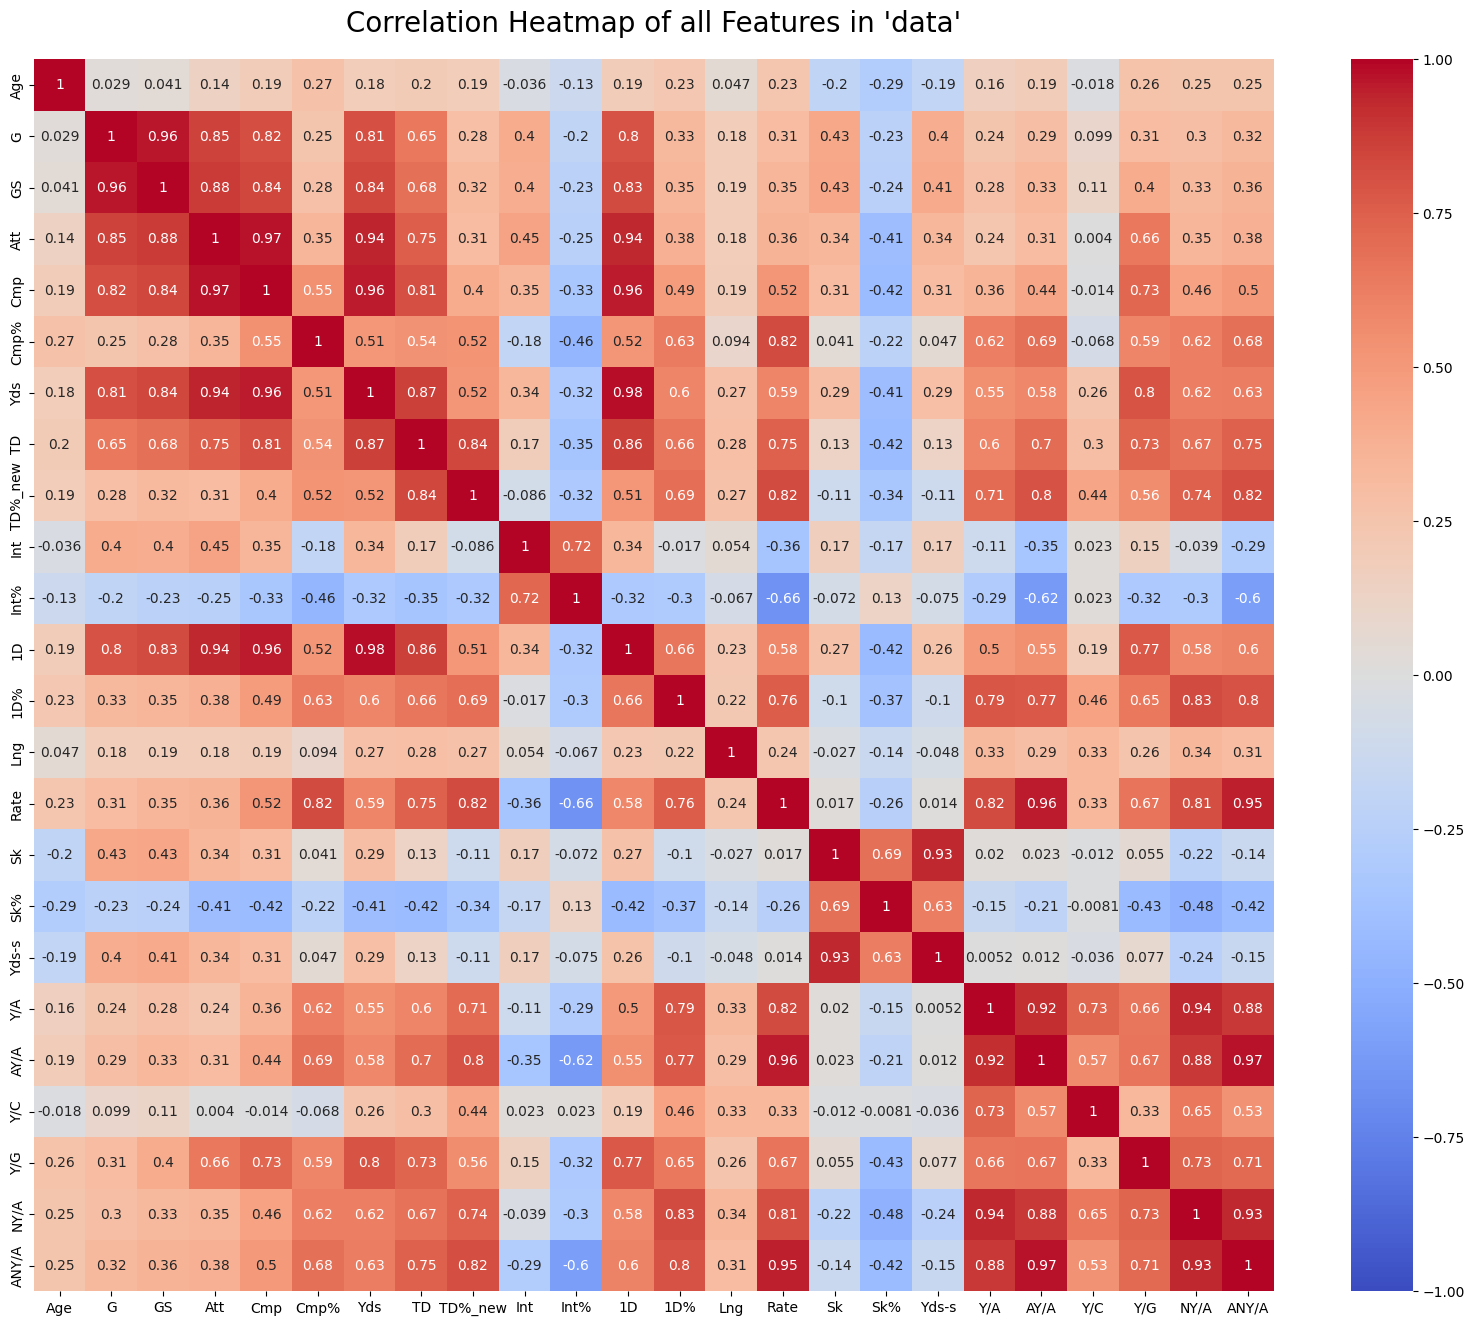

In [15]:
# Correlation plot of all features
fig= plt.figure(figsize=(20, 16))
corr_matrix = data.corr(method='pearson') # using pearson to inspect linear correlations 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of all Features in 'data'", pad=20.0, fontdict={'fontsize':20})
plt.show()

**Observations:**
- Age ('AG') doesn't have any strong linear correlation with other features $\Rightarrow$ maybe an indication for "age doesn't matter"
- Both Games Started ('GS') and Pass Attempts ('Att') seem to have a relative high correlation with the total number of Touchdowns ('TD') but not with Interceptions ('INT') $\Rightarrow$ so more games and attempts might have a bigger impact on the positive results rather than on negative metrics
- Both Total Number of Sacks ('Sk') and Sack Percentage ('Sk%') don't have any meaningful linear correlation with other features, so this metric might not be an important factor in passer evaluation/ranking $\Rightarrow$ might be obvious as a passer doesn't get the chance to throw the ball if he gets sacked by the opposing team, however someone might think that more sacks could influence the pass performance (e.g. psychological reasons)

## EDA Highlight 2

### Histogram, boxplot, and cumulative distribution table of Average Net Yards per Attempt ('ANY/A')

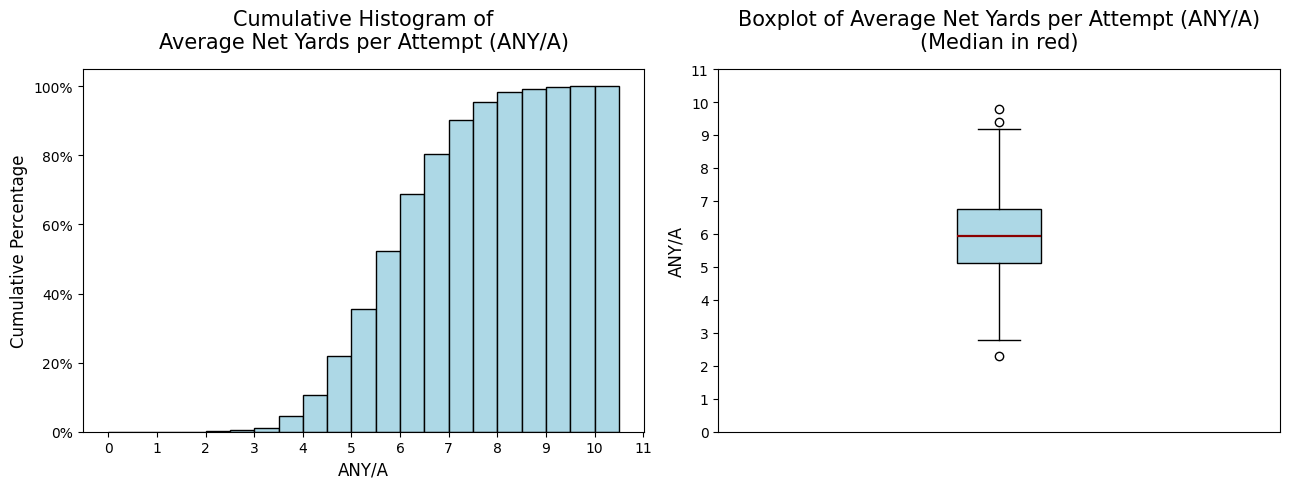

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ANY/A ≤,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00,5.50,6.00,6.50,7.00,7.50,8.00,8.50,9.00,9.50,10.00,10.50
Cumulative %,0.00,0.00,0.00,0.00,0.13,0.40,1.06,4.65,10.62,21.91,35.46,52.19,68.79,80.35,90.17,95.35,98.27,99.20,99.87,100.00,100.00


In [16]:
max_ANYA = max(data['ANY/A'])
start_x = 0
stop_x  = math.ceil(max_ANYA) + 1
step_x  = 0.5
x_range = [start_x + i * step_x for i in range(int((stop_x-start_x)/step_x))]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5)) 

ax1.hist(data['ANY/A'], cumulative=True, weights=np.ones(len(data)) / len(data), bins=x_range, color='lightblue', edgecolor='black') 
ax1.set_title("Cumulative Histogram of\nAverage Net Yards per Attempt (ANY/A)", fontsize=15, pad=15) 
ax1.set_xlabel('ANY/A', fontsize=12) 
ax1.set_xticks(range(12))
ax1.set_ylabel('Cumulative Percentage', fontsize=12) 
ax1.set_yticks(np.arange(0, 1.1, 0.20))          
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

bp = ax2.boxplot(data['ANY/A'], patch_artist=True)
for box in zip(bp['boxes'],bp['medians']):
    box[0].set(facecolor='lightblue')
    box[1].set(color='darkred', linewidth=1.6)
ax2.set_title('Boxplot of Average Net Yards per Attempt (ANY/A)\n(Median in red)', fontsize=15, pad=15)
ax2.set_xticks([])  # Remove x-axis tick labels
ax2.set_ylabel('ANY/A', fontsize=12)
ax2.set_yticks(range(12))

plt.tight_layout()
plt.show()

# Series of ANY/A values and same bin edges as in the histogram
anya = data['ANY/A']
bin_edges = x_range           
hist_counts = np.histogram(anya, bins=bin_edges)[0]

# Convert counts to cumulative counts
cum_pct = np.cumsum(hist_counts) / len(anya) * 100

# Build the cumulative distribution dataframe
cdf_table = pd.DataFrame({
    'ANY/A ≤': bin_edges[1:], # upper edge of each bin
    'Cumulative %': cum_pct
})

display(cdf_table.T.style.format("{:.2f}"))

**Observations:** 
- The majority of passers (around 80%) achieve ≤ 7.0 net yards per attempt
- 50% of the passers have an ANY/A of just under 6 yards
    
    $\Rightarrow$ For ANY/A just 1 yard is a huge difference
- Generally the distribution of ANY/A is symmetric, as the median is in the center of the box (same distnace between Q1-Q2 and Q2-Q3) and the whiskers are of equal length
- Very few outliers, which are neglectable

## EDA Highlight 3

### Pass Attempts vs. Rating scatter plot with color encoded Touchdown Percentage

Visualize how a passer is graded by the NFL passer rating with increasing pass attempts and how touchdown percentage fits into the picture.

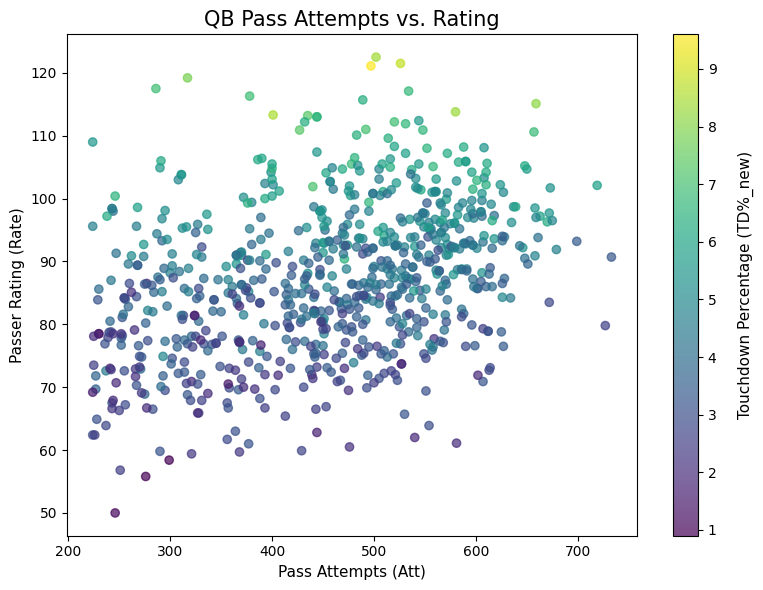

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(data['Att'], data['Rate'], 
                     c=data['TD%_new'], # colour‑encode by touchdown efficiency 
                     cmap='viridis', alpha=0.7)

ax.set_xlabel('Pass Attempts (Att)', fontsize = 11)
ax.set_ylabel('Passer Rating (Rate)', fontsize = 11)
ax.set_title('QB Pass Attempts vs. Rating', fontsize=15)
cbar = fig.colorbar(scatter)
cbar.set_label('Touchdown Percentage (TD%_new)',  fontsize=11, labelpad=15)

fig.tight_layout()
plt.show()

**Observations:**
- It doesn't seem that a passer gets a significant higher passer rating with more pass attempts, as with increasing attempts there is just a little shift of the data cloud to the upside
- The passers with a high passer rating also have a high touchdown percentage, which was expected as touchdowns are an important factor for the calculation of 'Rate'
- Overall more pass attempts (more playing experience) don't seem to increase the other 2 performance metrics 

# Task 5 -- Dimensionality Reduction

<div class="alert alert-block alert-warning"> 
<b>PCA</b>: 
Conduct your analyses and transformations according to Task 5.
Call the transformed dataset "data_pca".

(Commented code + bullet points, add cells below)
</div>

### Criteria/Goals for retaining principal components
- Each retained PC should explain ≥ 5 % of the total variance, as the original feature space is quite rich with 24 features.
- The retained set should account for at least 80 % of the cumulative variance.

**These thresholds should balance information retention with dimensionality reduction.**

### First Step before PCA: Scaling the data 

In [18]:
# Scale the data before applying PCA
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
data_sc_df = pd.DataFrame(data_sc, index=data.index, columns=data.columns) 
data_sc_df.head(5)

,Age,G,GS,Att,Cmp,Cmp%,Yds,TD,TD%_new,Int,Int%,1D,1D%,Lng,Rate,Sk,Sk%,Yds-s,Y/A,AY/A,Y/C,Y/G,NY/A,ANY/A
0,0.301742,0.76031,0.787948,0.791879,1.117381,1.444820,1.657596,1.810593,1.704702,2.341158,1.510099,1.554288,1.832646,-0.320101,1.203102,0.782318,0.071552,0.523575,2.227302,1.372480,1.541447,1.744458,2.017563,1.227489
1,-0.778162,0.76031,0.787948,0.800461,0.724742,0.115864,0.928469,0.670932,0.345167,2.564083,1.724850,0.900263,0.661720,1.363784,-0.253671,-0.085118,-0.651971,0.509667,0.658153,-0.167852,0.604636,0.693814,0.661442,-0.063443
2,0.733704,0.76031,0.787948,0.482927,0.368913,-0.127777,0.709418,1.354728,1.544757,0.780682,0.328971,0.614126,0.731976,-0.159731,0.588394,-0.759791,-1.086085,-0.616806,0.788916,0.687888,1.125087,0.378861,1.055950,0.898428
3,-0.778162,0.76031,0.787948,0.894862,0.344374,-1.390285,0.616582,0.670932,0.185222,2.341158,1.402724,0.511935,-0.509205,-0.480471,-0.902061,1.938899,0.891544,1.872561,-0.257183,-0.681297,0.916906,0.244225,-0.583723,-0.814378
4,1.597627,0.76031,0.787948,0.817625,0.945601,0.802491,0.612410,0.784898,0.505113,-0.556869,-1.066909,0.777633,0.427535,-1.603061,0.706283,-0.277882,-0.796676,-0.561177,-0.126421,0.345592,-0.852627,0.239416,0.180636,0.552492


### Applying PCA to 'data'

In [19]:
first_pca = PCA()
data_pca_unred = first_pca.fit_transform(data_sc) # unred = unreduced
data_pca_unred = pd.DataFrame(data_pca_unred, index=data.index)
data_pca_unred.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,5.707013,0.572508,-0.287112,2.727195,-2.498428,-0.906627,-0.221911,0.471148,0.045279,-0.256437,-0.214428,0.026187,-0.179950,-0.165160,0.243305,0.011746,0.093984,0.006120,0.061704,0.030877,0.000475,0.051310,-0.012927,-0.004671
1,1.996791,1.946587,-1.731920,2.562827,-0.283619,-0.101207,-1.285107,0.267243,-0.247942,-0.001148,0.501597,-0.011250,-0.077016,-0.285481,0.114039,0.005053,0.068122,-0.033025,-0.008942,0.030654,0.024314,-0.025359,0.010249,0.000482
2,3.071178,-0.538236,-1.542161,0.981481,-0.039414,-0.421004,1.140352,0.781105,0.428885,-0.205688,0.114777,0.023801,0.022349,-0.108191,0.061152,0.050183,-0.031806,0.000614,0.013568,-0.017438,0.008568,-0.040304,-0.011425,-0.004670
3,-0.224912,3.976784,0.503425,2.525423,-0.629531,-0.533471,0.490033,0.061945,1.180971,-0.049141,0.160470,0.182928,-0.334671,-0.082590,0.149328,-0.017951,-0.076501,0.019018,-0.016077,-0.045517,0.011842,-0.056922,-0.002860,0.007799
4,2.242260,0.179684,-0.700907,-2.541662,-0.682520,-0.338776,1.404657,0.322791,-0.042298,-0.022854,-0.320535,0.024012,0.088831,0.046908,-0.049386,-0.014982,-0.044838,0.013038,-0.020430,0.009621,0.039548,-0.034591,-0.013439,-0.001497


### Let's have a look on the covariance matrix of 'data_pca_unred'

In [20]:
data_pca_unred.cov().round(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,11.3291,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000
1,0.0000,4.3303,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
2,0.0000,-0.0000,2.4409,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000
3,-0.0000,-0.0000,0.0000,1.8417,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000
4,0.0000,-0.0000,0.0000,0.0000,1.0073,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
5,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.8403,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.6898,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000
7,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.5708,-0.0000,-0.0000,0.0000,0.0000,0.000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
8,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.4737,0.0000,0.0000,0.0000,-0.000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000
9,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.2568,-0.0000,-0.0000,0.000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000


### Now let's find out how much of the total variance the individual principal components hold

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Indiv. expl. VAR,0.47,0.18,0.10,0.08,0.04,0.03,0.03,0.02,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Accum. expl. VAR,0.47,0.65,0.75,0.83,0.87,0.91,0.94,0.96,0.98,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Keeping 4 components (83.0% variance)


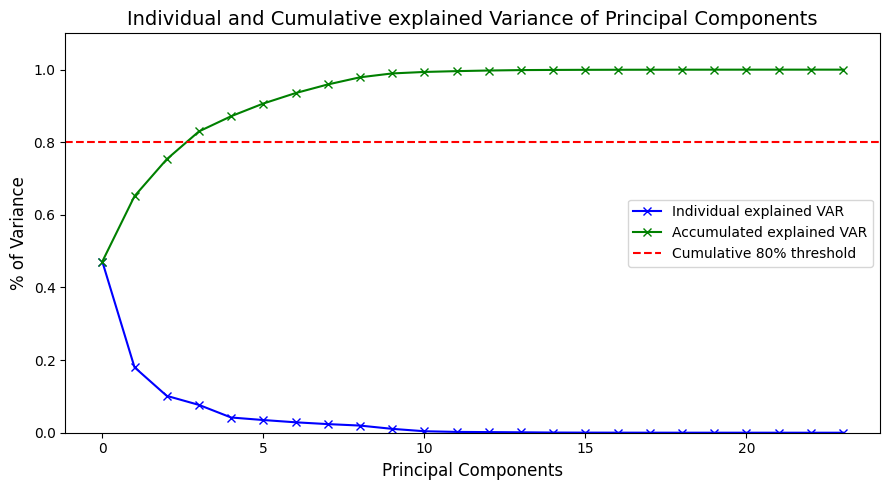

In [21]:
expl_var_ratio = first_pca.explained_variance_ratio_  # explained variance of each individual PC
accum_expl_var = np.add.accumulate(expl_var_ratio)    # accumulated explained variance of each individual PC

expl_var_df = pd.DataFrame({'Indiv. expl. VAR':expl_var_ratio, 'Accum. expl. VAR':accum_expl_var})
display(expl_var_df.T.round(2).style.format("{:.2f}"))

# Set a threshold for how much of the total variance should explained by the kept PCs: 80%
n = np.argmax(accum_expl_var >= 0.80) + 1 # n will be used in the next step too
print(f"Keeping {n} components ({accum_expl_var[n-1]:.1%} variance)")

plt.figure(figsize=(9,5))
plt.plot(expl_var_ratio, marker='x', label='Individual explained VAR', c='blue')
plt.plot(accum_expl_var, marker='x', label='Accumulated explained VAR', c='green')
plt.axhline(0.80, color='red', linestyle='--', label= 'Cumulative 80% threshold')
plt.ylim([0, 1.1])
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('% of Variance', fontsize=12)
plt.title('Individual and Cumulative explained Variance of Principal Components', fontsize=14)
plt.tight_layout()
plt.legend(loc='center right')

**Observations:**
- PC 1 explains almost half (≈ 47%) of the total variance.
- Just the first 4 principal components each account for at least 5% of the overall explained variance.
- The first 4 principal components together account for ≈ 83% of the cumulative variance. Also, 4 components are needed to meet the criteria of keeping at least 80% of the total variance.

**Conclusion**: The first 4 prinicipal components are retained, as each of them contribute at least 5% to the overall variance. Together they make up ≈ 83% of the total variance. So by keeping the first 4 components the selection criteria mentioned at the beginning are met.

### Applying the selected PCA transformation (first 4 PC) and call the result 'data_pca'

In [22]:
final_pca = PCA(n_components=n) # n was defined in the last code cell
data_pca = final_pca.fit_transform(data_sc)

data_pca  = pd.DataFrame(
    data_pca,
    index=data.index,
    columns=[f'PC{i+1}' for i in range(n)]
)
data_pca.head(5)

,PC1,PC2,PC3,PC4
0,5.707013,0.572508,-0.287112,2.727195
1,1.996791,1.946587,-1.731920,2.562827
2,3.071178,-0.538236,-1.542161,0.981481
3,-0.224912,3.976784,0.503425,2.525423
4,2.242260,0.179684,-0.700907,-2.541662


### Finally let's inspect the highest loading for each of the final 4 PC in 'data_pca', meaning which of the original features contribute the most to PC1-PC4

In [23]:
loadings = pd.DataFrame(
    final_pca.components_.T,
    index=data.columns,
    columns=data_pca.columns
).round(2)

for pc in data_pca.columns:
    max_load_ft = loadings[pc].max()
    features = [feature for feature in loadings[loadings[pc] == loadings[pc].max()].index]
    print(f'Highest loading for {pc} = {max_load_ft} from feature(s): {', '.join(features)}')  

Highest loading for PC1 = 0.27 from feature(s): Yds, TD, ANY/A
Highest loading for PC2 = 0.32 from feature(s): Sk, Yds-s
Highest loading for PC3 = 0.52 from feature(s): Sk%
Highest loading for PC4 = 0.55 from feature(s): Y/C


# Task 6 -- Clustering

<div class="alert alert-block alert-warning"> 
<b>Choice of Algorithm</b>: 
Given the situation in the pitch and the results from the above analyses. Which algorithm (chosen from those discussed in the lectures) would YOU choose for the clustering? Explain!
    
(Choice + 1-3 bullet points in the cell below)
</div>

**My Choice: k-Means++**

- **One dominant PC in PCA space:** PC1 carries by far the most weight (≈ 47%) $\Rightarrow$ data points form one broad, rounded cloud rather than long skinny streaks; any sub-groups would appear as spherical forms within that cloud, which is the shape k-Means++' model expect

- **Centroid output is easy to interpret:** Each cluster is summarised by a single, concrete season-profile "centroid", which coaches and front-office staff can compare directly to a current quarterback’s stats $\Rightarrow$ k-means++ should return centroids as QB prototypes

- **Scalable and reproducible:** k-Means++ runs quickly on 753 passer-season entries, gives consistent results with a fixed random seed, and offers straightforward hyperparameter variation (experimenting with a small range of k values)

<div class="alert alert-block alert-danger"> 
<b>Requirements</b>: 
In the following and for the remainder of the final phase of the exam (indenpendent of what your choice above suggests), use 

* a clustering algorithm $A$ chosen from the family: __k-means/k-means++__
* the evaluation metric $E_1$: __Silhouette Score__
* the evaluation metric $E_2$: __Davies-Bouldin Index__.
</div>

## Comprehensive clustering analysis
<div class="alert alert-block alert-warning"> 
<b>Clustering</b>: 

On both datasets, data and data_pca, under their respective headlines below, conduct comprehensive clustering analyses with algorithm $A$, using the available methodology from the module and specifically $E_1$ and $E_2$. Conduct ALL necessary steps to create the most helpful and meaningful clustering per dataset and discuss its quality. Use appropriate diagrams to demonstrate the results. 

(Commented code + bullet points, add cells)
</div>

### Clustering Analysis of plain data

At the beginning of task 5 we scaled 'data' and assigned it to the variable 'data_sc', which will be used for this first part because:
- **Unit-variance features:** k-Means rely on euclidean distance $\Rightarrow$ Z-scoring prevents large-scale variables such as 'Yds' or 'Att' from dwarfing smaller-scale metrics like percentages.
- **Consistency with the PCA run:** Keeping the same scaling method lets us compare cluster quality on data and data_pca without a hidden scale bias.
- **Better outlier handling than Min-Max:** MinMaxScaler stretches the 0-to-1 range to include extreme outliers 
- **Conventional choice for mixed-unit numeric data:** Z-scoring is the standard preprocessing step recommended in the scikit-learn documentation for distance-based clustering on heterogeneous feature sets

#### Run k-Means++ with varying hyperparamters: different k-values as different number of clusters

,Algorithm,k,Silhouette Score,Davies-Bouldin Index
0,k-Means++,2,0.267304,1.392438
1,k-Means++,3,0.204218,1.566735
2,k-Means++,4,0.193391,1.531555
3,k-Means++,5,0.150093,1.720594
4,k-Means++,6,0.146466,1.769196
5,k-Means++,7,0.140658,1.778916
6,k-Means++,8,0.134620,1.855867
7,k-Means++,9,0.127608,1.819895


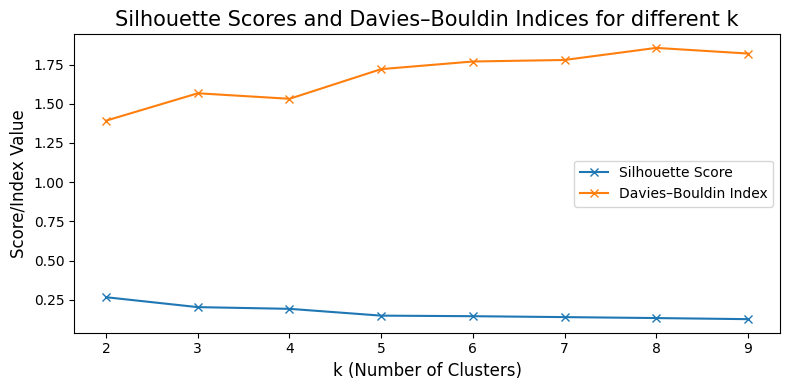

In [24]:
# Collect evaluation data for 'data' clusterings
results_data = [] 
avg_silh_scores = {}
avg_dbi = {}

# Set hyperparamters
random_state = 42
n_init = 30
init = 'k-means++'
k_values = list(range(2,10)) # k-values for k-Means++ 

# Compute k-Means++, silhouette score, and DBI for different k 
for k in k_values:
    kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=random_state)
    kmeans_labels = kmeans.fit_predict(data_sc)
    silh_score = silhouette_score(data_sc, labels=kmeans_labels, metric='euclidean')
    avg_silh_scores[k] = silh_score
    dbi = davies_bouldin_score(data_sc, labels=kmeans_labels)
    avg_dbi[k] = dbi
    results_data.append({'Algorithm':'k-Means++', 'k':k, 'Silhouette Score':silh_score, 'Davies-Bouldin Index':dbi})

df_res = pd.DataFrame(results_data) 
display(df_res) # Show table with results

# Plot the change of silhouette scores and davies-bouldin indices with increasing k
plt.figure(figsize=(8,4))
plt.plot(df_res['k'], df_res['Silhouette Score'],
         marker='x', label='Silhouette Score')
plt.plot(df_res['k'], df_res['Davies-Bouldin Index'],
         marker='x', label='Davies–Bouldin Index')
plt.xlabel('k (Number of Clusters)', fontdict={'fontsize':12})
plt.ylabel('Score/Index Value', fontdict={'fontsize':12})
plt.title('Silhouette Scores and Davies–Bouldin Indices for different k', fontdict={'fontsize':15})
plt.legend(loc='center right')
plt.tight_layout() 
plt.show()

**Observations:**
- The highest silhouette score is ≈0.27 and obtained for k=2 $\Rightarrow$ weak structure
- Davies-Bouldin Index is calculated over all cluster of a clustering as the average of the maximum ratios of intra-cluster distances to inter-cluster distances  $\Rightarrow$ index value can be any number from $\mathbb{R}_{\geq 0}$ with lower score indicating better clustering
- Here the best Davies-Bouldin Index also results from k=2 with a value of ≈1.39 $\Rightarrow$ clusters aren't well-separated, as ratio of intra-cluster distances to inter-cluster distances isn't good, so moderate to poor clustering 

**Conclusion**: Considering the Silhouette Score of 0.27 and the Davies-Bouldin Index of 1.39, the clustering seems to have a relatively weak structure and poor separation between clusters. Also, these metrics already aren't good for k=2, the minimum number of clusters. This suggests that the data may lack clear clustering structure in general.

### Visualization of the best clustering result with k=2

k-Means++ is re-computed for k = 2 to obtain the labels. Next, for every possible pair of original features, the silhouette score is calculated by **using those two features only**. The pair with the highest silhouette is then used as the x- and y-axes for the visualisation. Silhouette is used as criteria because it measures how well-separated clusters are. A high silhouette means individual points clearly belong to their clusters, making it intuitive for visual inspection. In contrast, DBI focuses on ratios of cluster distribution to separation, making it more abstract and less intuitive for choosing axes to visualize clearly separated clusters. However the best pair(s) for both metrics are given out at the end.

Evaluation Metrics, if just the best feature pair is used for calculation (all other features are ignored):
Best Silhouette pair: ('TD', 'NY/A'), Silhouette Score of best pair: 0.476
Best DBI pair: ('TD', 'NY/A'), Davies-Bouldin Index of best pair: 0.660


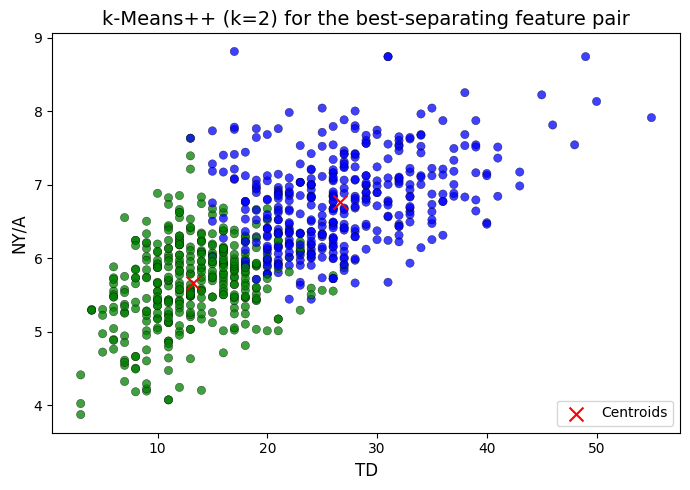

In [25]:
best_k = 2
kmeans = KMeans(n_clusters=best_k, init=init, n_init=n_init, random_state=random_state)
kmeans_labels = kmeans.fit_predict(data_sc)
centers_plot = scaler.inverse_transform(kmeans.cluster_centers_)

best_silh_score, best_dbi = -1, float('inf') # -1 is worst score for Silhouette, infinity is worst score for DBI
dic_silh_scores = {}
dic_dbi = {}

for f1, f2 in itertools.combinations(data.columns, 2):
    feature_pair = data[[f1, f2]].values
    silh_score = silhouette_score(feature_pair, labels=kmeans_labels) 
    dbi = davies_bouldin_score(feature_pair, labels=kmeans_labels)
    dic_silh_scores[(f1, f2)] = silh_score
    dic_dbi[(f1, f2)] = dbi
    if silh_score > best_silh_score:  # higher means better for Silhouette
        best_silh_score  = silh_score
        best_silh_pair = (f1, f2)
        loc_1, loc_2 = data.columns.get_loc(f1), data.columns.get_loc(f2) # save indices of features for plot
    if dbi < best_dbi:                # lower means better for DBI
        best_dbi = dbi
        best_dbi_pair = (f1, f2)

print('Evaluation Metrics, if just the best feature pair is used for calculation (all other features are ignored):')
print(f"Best Silhouette pair: {best_silh_pair}, Silhouette Score of best pair: {best_silh_score:.3f}")
print(f"Best DBI pair: {best_dbi_pair}, Davies-Bouldin Index of best pair: {best_dbi:.3f}")

# Set x and y as the best pair we got from the loop, and define colors and colormap for clusters
x, y = best_silh_pair
colors = ['blue', 'green']
cmap   = ListedColormap(colors)

plt.figure(figsize=(7,5))
plt.scatter(data[x], data[y], c=kmeans_labels, cmap=cmap, alpha=0.75, edgecolor='k', linewidth=0.3)
plt.scatter(centers_plot[:, loc_1], centers_plot[:, loc_2], marker='x', s=100, c='red', label='Centroids')
plt.xlabel(x, fontsize=12)
plt.ylabel(y, fontsize=12)
plt.title('k-Means++ (k=2) for the best-separating feature pair', fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

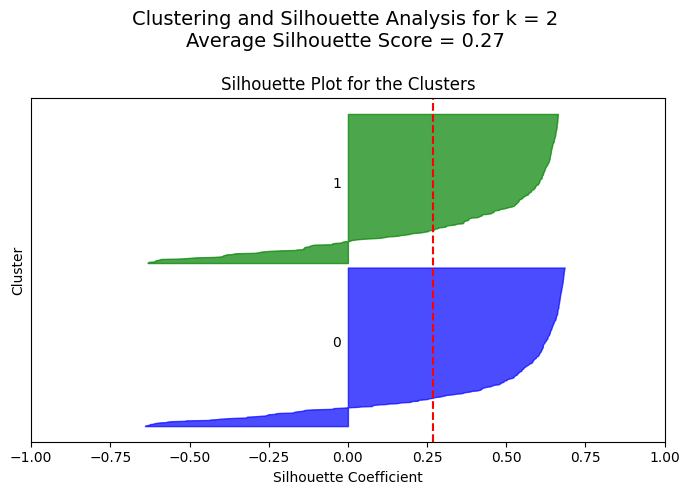

In [26]:
silhouette_vals = silhouette_samples(data, kmeans_labels)

plt.figure(figsize=(7,5))
y_lower = 10  # Starting position for the first cluster's silhouette plot
for i in range(best_k):
    # Aggregate silhouette scores for samples belonging to cluster i, then sort them
    ith_cluster_silhouette_vals = silhouette_vals[kmeans_labels == i]
    ith_cluster_silhouette_vals.sort()
    
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    # Use same color as in the scatter:
    color = colors[i]
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters

plt.axvline(x=avg_silh_scores[best_k], color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot for the Clusters")
plt.yticks([])  # Clear the y-axis labels/ticks
plt.xlim([-1, 1])
plt.suptitle(f"Clustering and Silhouette Analysis for k = {best_k}\nAverage Silhouette Score = {avg_silh_scores[best_k]:.2f}", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

**Observations:**
- Evaluation Metrics and Scatter Plot:
    - Both evaluation metrics improve when just the best feature pair is used for the calculations
    - Silhouette score still indicates a weak structure, but DBI indicates that the ratio of intra-cluster distribution to inter-cluster separation is somewhat low (which is good)
    - The plot shows two groups: one with low number of touchdowns and less net yards per attempt, the other one with a higher number of touchdowns and more net yards per attempt
    - Some data points of one cluster overlap with the other cluster, resulting from the fact that we just plot a 2-D-projection of a 24-D-feature space

- Silhouette Plot:
    - 2 clusters have been created of similar size 
    - Also, both clusters have the same structure regarding the individual silhouettes of their assigned data points
    - The overall silhouette coefficient suggests a weak clustering structure, however many individual silhouettes have at least a usable score
    - Reason for the low average silhouette: both clusters contain data points with a (high) negative value, meaning they might be assigned to the wrong cluster $\Rightarrow$ these are the "overlapping" points in the scatter plot!

**Meaning/Interpretation:**
- Generally in the full 24-D-feature space the clustering is structured poorly, and even just improves slightly when the best feature pair for the evaluation metrics is used
- 2-D projection can be misleading, because only looking only at TD vs. NY/A, you don’t capture the axis along which k-Means actually split the data (clustering boundary lives in a combination of multiple metrics)
- For the calculation of NY/A the total number of yards is used. But if a passer just throws more and more yards, over time the number of touchdowns should also increase (you will be successful if you just try often enough). So an increase in both features, NY/A and TD, could just be a result of an increase in Yds, thus not necessarily meaning they provide a good feature pair for discovering QB archetypes.

### Clustering Analysis of PCA transformed data

#### Same procedure as for plain data: run k-Means++ with varying hyperparamters: different k-values as different number of clusters (no need for scaling, as it was already done for PCA)

,Algorithm,k,Silhouette Score,Davies-Bouldin Index
0,k-Means++,2,0.323683,1.180181
1,k-Means++,3,0.264989,1.280749
2,k-Means++,4,0.250985,1.234265
3,k-Means++,5,0.211114,1.367794
4,k-Means++,6,0.209894,1.404413
5,k-Means++,7,0.206852,1.375975
6,k-Means++,8,0.202889,1.410357
7,k-Means++,9,0.198142,1.354399


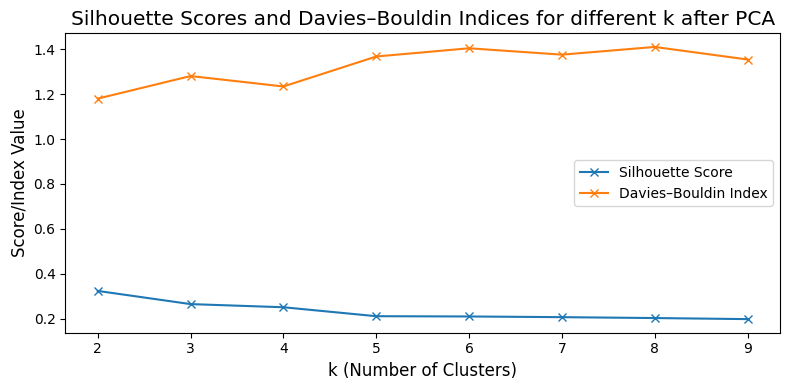

<Figure size 640x480 with 0 Axes>

In [27]:
# Collect evaluation data for 'data' clusterings
results_data_pca = [] 
avg_silh_scores_pca = {}
avg_dbi_pca = {}

#########################################################################
# No new hyperparameters -> same as for plain data, to make it comparable
#########################################################################

# Compute k-Means++, silhouette score, and DBI for different k 
for k in k_values:
    kmeans_pca = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=random_state)
    kmeans_labels_pca = kmeans_pca.fit_predict(data_pca.values)
    silh_score_pca = silhouette_score(data_pca.values, labels=kmeans_labels_pca, metric='euclidean')
    avg_silh_scores_pca[k] = silh_score_pca
    dbi_pca = davies_bouldin_score(data_pca.values, labels=kmeans_labels_pca)
    avg_dbi_pca[k] = dbi_pca
    results_data_pca.append({'Algorithm':'k-Means++', 'k':k, 'Silhouette Score':silh_score_pca, 'Davies-Bouldin Index':dbi_pca})

df_res_pca = pd.DataFrame(results_data_pca) 
display(df_res_pca) # show table with results

# Plot the change of silhouette scores and davies-bouldin indices with increasing k
plt.figure(figsize=(8,4))
plt.plot(df_res_pca['k'], df_res_pca['Silhouette Score'],
         marker='x', label='Silhouette Score')
plt.plot(df_res_pca['k'], df_res_pca['Davies-Bouldin Index'],
         marker='x', label='Davies–Bouldin Index')
plt.xlabel('k (Number of Clusters)', fontdict={'fontsize':12})
plt.ylabel('Score/Index Value', fontdict={'fontsize':12})
plt.title('Silhouette Scores and Davies–Bouldin Indices for different k after PCA', fontdict={'fontsize':14.5})
plt.legend(loc='center right')
plt.tight_layout() 
plt.show()
plt.tight_layout()
plt.show()

**Observations:**
- Again, for both evaluation metrics the best value is obtained for k=2
- The highest silhouette score is ≈0.32 (0.27 for plain data) $\Rightarrow$ still weak structure
- The lowest Davies-Bouldin Index is now ≈1.18 (1.39 for plain data) $\Rightarrow$ clusters still aren't well-separated, as ratio of intra-cluster distances to inter-cluster distances isn't good, so moderate to poor clustering 

**Conclusion**: Considering these results, the clustering still seems to have a relatively weak structure and poor separation between clusters. Again, these metrics already aren't good for k=2, the minimum number of clusters, so PCA might not improved anything.

### Visualization of the best clustering result with k=2

Again, k-Means++ is re-computed for k = 2 to obtain the labels. Next, for every possible pair of original features, the silhouette score is calculated by **using those two features only**. The pair with the highest silhouette is then used as the x- and y-axes for the visualisation. Silhouette is used as criteria, but the best pair(s) for both metrics are given out at the end.

Evaluation Metrics, if just the best feature pair is used for calculation (all other features are ignored):
Best Silhouette pair: ('PC1', 'PC4'), Silhouette Score of best pair: 0.476
Best DBI pair: ('PC1', 'PC4'), Davies-Bouldin Index of best pair: 0.751


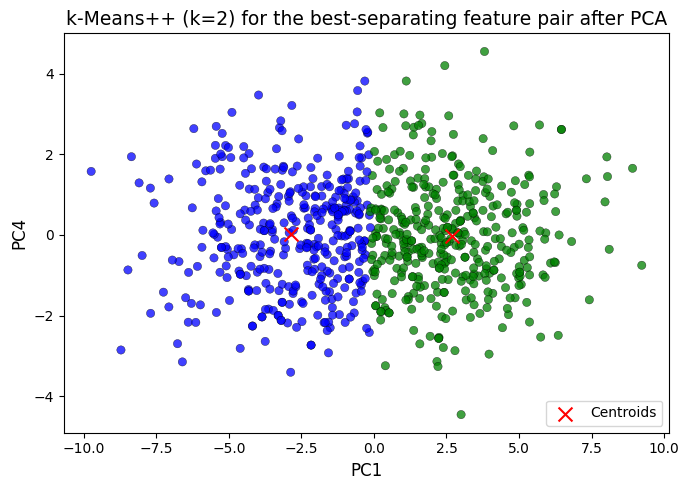

In [28]:
best_k_pca = 2
kmeans_pca = KMeans(n_clusters=best_k_pca, init=init, n_init=n_init, random_state=random_state)
kmeans_labels_pca = kmeans_pca.fit_predict(data_pca.values)
centers_plot = kmeans_pca.cluster_centers_

best_silh_score_pca, best_dbi_pca = -1, float('inf') # -1 is worst score for Silhouette, infinity is worst score for DBI
dic_silh_scores_pca = {}
dic_dbi_pca = {}

for f1, f2 in itertools.combinations(data_pca.columns, 2):
    feature_pair_pca = data_pca[[f1, f2]].values
    silh_score_pca = silhouette_score(feature_pair_pca, labels=kmeans_labels_pca) 
    dbi_pca = davies_bouldin_score(feature_pair_pca, labels=kmeans_labels_pca)
    dic_silh_scores_pca[(f1, f2)] = silh_score_pca
    dic_dbi_pca[(f1, f2)] = dbi_pca
    if silh_score_pca > best_silh_score_pca:     # higher means better for Silhouette
        best_silh_score_pca  = silh_score_pca
        best_silh_pair_pca = (f1, f2)
        loc_1, loc_2 = data_pca.columns.get_loc(f1), data_pca.columns.get_loc(f2) # save indices of PCs for plot
    if dbi_pca < best_dbi_pca:                   # lower means better for DBI
        best_dbi_pca = dbi_pca
        best_dbi_pair_pca = (f1, f2)

print('Evaluation Metrics, if just the best feature pair is used for calculation (all other features are ignored):')
print(f'Best Silhouette pair: {best_silh_pair_pca}, Silhouette Score of best pair: {best_silh_score_pca:.3f}')
print(f'Best DBI pair: {best_dbi_pair_pca}, Davies-Bouldin Index of best pair: {best_dbi_pca:.3f}')

x, y = best_silh_pair_pca
# Define colors and colormap for clusters
colors = ['blue', 'green']
cmap   = ListedColormap(colors)

plt.figure(figsize=(7,5))
plt.scatter(data_pca[x], data_pca[y], c=kmeans_labels_pca, cmap=cmap, alpha=0.75, edgecolor='k', linewidth=0.3)
plt.scatter(centers_plot[:, loc_1], centers_plot[:, loc_2], marker='x', s=100, c='red', label='Centroids')
plt.xlabel(x, fontsize=12)
plt.ylabel(y, fontsize=12)
plt.title('k-Means++ (k=2) for the best-separating feature pair after PCA', fontsize=13.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

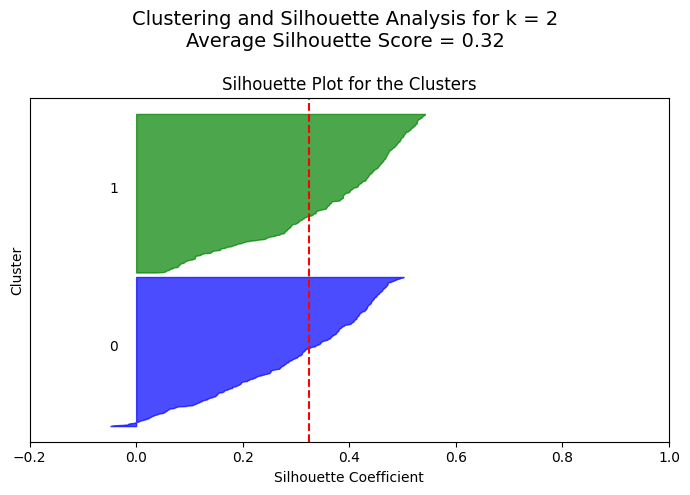

In [29]:
silhouette_vals_pca = silhouette_samples(data_pca, kmeans_labels_pca)

plt.figure(figsize=(7,5))
y_lower_pca = 10  # Starting position for the first cluster's silhouette plot
for i in range(best_k_pca):
    # Aggregate silhouette scores for samples belonging to cluster i,
    # then sort them.
    ith_cluster_silhouette_vals_pca = silhouette_vals_pca[kmeans_labels_pca == i]
    ith_cluster_silhouette_vals_pca.sort()
    
    size_cluster_i_pca = ith_cluster_silhouette_vals_pca.shape[0]
    y_upper_pca = y_lower_pca + size_cluster_i_pca
    # Use same color as in the scatter:
    color = colors[i]
    plt.fill_betweenx(np.arange(y_lower_pca, y_upper_pca),
                      0, ith_cluster_silhouette_vals_pca,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower_pca + 0.5 * size_cluster_i_pca, str(i))
    
    y_lower_pca = y_upper_pca + 10  # 10 for the 0 samples gap between clusters

plt.axvline(x=avg_silh_scores_pca[best_k_pca], color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot for the Clusters")
plt.yticks([])  # Clear the y-axis labels/ticks
plt.xlim([-0.2, 1])
plt.suptitle(f"Clustering and Silhouette Analysis for k = {best_k_pca}\nAverage Silhouette Score = {avg_silh_scores_pca[best_k_pca]:.2f}", 
             fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

**Observations:**
- Evaluation Metrics and Scatter Plot:
    - Again as for the plain data, both evaluation metrics improve when just the best feature pair is used for the calculations
    - Silhouette score still indicates a weak structure but is almost at a 'usable structure' value
    - DBI indicates that the distribution within clusters is now low and separation betwenn clusters is high(er) in comparison to comparison to this distribution, however the scatter plot shows a different picture
    - The plot shows two clusters because we set k=2 in the beginning, otherwise all data points/passers would fall into one big group with some outliers at the border
    - Overall the algorithm just splits the big cluster into 2 clusters, because we told it to do so

- Silhouette Plot:
    - 2 clusters have been created of similar size 
    - Also, both clusters have the same structure regarding the individual silhouettes of their assigned data points
    - The overall silhouette coefficient suggests a weak clustering structure, which is underlined by many individual silhouettes which show a low score (no matter if the the indiviual silhouette is above or below the average silhouette score of the whole clustering)
    - One improvement in comparison to the plain data: there are just a few data points with a negative silhouette

**Meaning/Interpretation:**
- Overall the same result stands as for the plain data
- Generally the 4-D-PC space the clustering is structured poorly
- It improves slightly when the best feature pair for the evaluation metrics is used and comes near to a usable structure, but as a good clustering for the 4 PCs is desired this isn't helpful
- Furthermore the scatter plot just shows a half cutted data cloud for the best feature pair, which doesn't indicate a good clustering into different quarterback archetypes
- So PCA cleaned up some variance noise and slightly sharpened clusters, but the improvement is too small to claim distinct groups $\Rightarrow$ QB seasons in the PC-space still form a near-continuous distribution rather than different archetypes

# Task 7 -- Clustering Comparison

<div class="alert alert-block alert-warning"> 
<b>Comparison</b>: 
Compare both clustering from the previous task as described in Task 7.

(Commented code + bullet points, add cells below)
</div>

**Note/Statement on noise points:**

- Number of noise points is always zero with k-Means++, as algorithm assigns every point to its nearest centroid in every iteration 
- Unlike density-based methods (e.g. DBSCAN, OPTICS) it has no special label such as –1 to mark outliers $\Rightarrow$ all data entries end up in one of the k clusters

In [30]:
# 1. Collect basic facts for each clustering
# As desribed above there are no noise points, but let's also check that
noise_raw = np.sum(kmeans_labels   == -1)   
noise_pca = np.sum(kmeans_labels_pca == -1)  

print('Comparison of number of clusters and noise points, as well as evaluation metrics:')

row_names = ['Number of Clusters (k)',
             'Number of Noise points',
             'Silhouette Score (E₁)',
             'Davies–Bouldin Index (E₂)']

compare_df = pd.DataFrame(
    {
        'Plain feature matrix': [f'{best_k:.0f}',
                               f'{noise_raw:.0f}',
                               f'{round(avg_silh_scores[best_k],2)}',
                               f'{round(avg_dbi[best_k],2)}'],
        'PCA matrix':         [f'{best_k_pca:.0f}',
                               f'{noise_pca:.0f}',
                               f'{round(avg_silh_scores_pca[best_k_pca],2)}',
                               f'{round(avg_dbi_pca[best_k_pca],2)}']
    },
    index=row_names
).round(2)

display(compare_df)
print()

# 2. Relationship table 
print('Relationship between the 2 clusterings, regarding the data instances:') 
rel = pd.crosstab(kmeans_labels, kmeans_labels_pca,
                  rownames=['Plain k-Means cluster'],
                  colnames=['PCA k-Means cluster'])
display(rel)

Comparison of number of clusters and noise points, as well as evaluation metrics:


,Plain feature matrix,PCA matrix
Number of Clusters (k),2,2
Number of Noise points,0,0
Silhouette Score (E₁),0.27,0.32
Davies–Bouldin Index (E₂),1.39,1.18



Relationship between the 2 clusterings, regarding the data instances:


PCA k-Means cluster,0,1
Plain k-Means cluster,,
0,0,388
1,365,0


**Observations:**

- As the best k is 2 for both clusterings, the number of clusters is similar and each cluster is of somewhat similar size
- As mentioned above there are no noise points
- In both cases the silhouette score indicates a weak clustering structure
- Also in both cases the Davies-Bouldin Index is above 1, so the sum of inner cluster distributions is high in ratio to the inter-cluster distance $\Rightarrow$ indication that the cluster result isn't good
- Each cluster from the plain feature matrix maps into exactly one PCA cluster, the labeling (0 ↔ 1) flipped but the structure seems to be preserved $\Rightarrow$ PCA didn't fundamentally change the group assignments, but slightly improved the compactness

**Conclusions**: 
- Both clusterings (plain and PCA) find the same two main groups of quarterbacks, which is a result of k=2 set in the beginning
- PCA improves clustering quality slightly (better E₁ and E₂) but does not change which players are grouped together
- The "flip" in cluster labels is irrelevant for interpretation (labels 0 and 1 are arbitrary in k-Means)

$$\Downarrow$$ 

**Despite small improvements in clustering quality after PCA, both the plain and PCA-transformed analyses show that quarterback passing seasons form a big continuum rather than distinct archetypes, so no clear business-actionable cluster structure emerged!**



# Task 8 -- Conclusions and Future Work

<div class="alert alert-block alert-warning"> 
<b>Subtasks</b>: 
For each subtask, create a fitting headline and add additional code and markdown cells below to conduct the respective task.
    
(Commented code + bullet points, add cells below)
</div>


## 1. The Final Clustering Selection: PCA

- I select the clustering based on the **PCA-reduced feature matrix** as my final result
- PCA revealed that a large proportion of variance (≈47%) was captured by PC1, suggesting strong correlations among original features $\Rightarrow$ dimensionality reduction helped to compress redundant information
- PCA clustering achieved a **higher Silhouette Score (0.32 vs 0.27)** and a **lower Davies–Bouldin Index (1.18 vs 1.39)** compared to the plain feature matrix clustering
- Dimensionality reduction slightly improved cluster compactness and separation (overlapping data points in the plain data clustering), while preserving the overall structure
- Thus, the PCA-based clustering offers the cleanest and more reliable grouping available for further interpretation


## 2. Feature Discussion

In [31]:
# Step 1: Create a DataFrame that includes cluster labels
data_clusters = data.copy()                   # original (unscaled) features
data_clusters['Cluster'] = kmeans_labels_pca  # assign PCA-based labels to the original data

# Step 2: Calculate means for features per cluster
cluster_means = data_clusters.groupby('Cluster').mean()

# Step 3: Focus on key features 
selected_features = ['Age', 'Yds', 'Cmp%', 'TD%_new', 'Sk%', 'ANY/A', 'Rate']

display(cluster_means[selected_features].round(2))

,Age,Yds,Cmp%,TD%_new,Sk%,ANY/A,Rate
Cluster,,,,,,,
0,27.67,2491.47,59.64,3.26,7.12,5.06,78.47
1,29.48,3945.90,64.56,4.83,5.63,6.79,95.24


**Observations:**

- Cluster 0 quarterbacks generally throw less yards, have lower passing AND touchdown efficiency, and higher sack rates, indicating less effective or struggling passers
- Cluster 1 quarterbacks show higher passing yards, better passing AND touchdown efficiency, lower sack percentage, higher adjusted net yards per attempt, all leading to higher passer ratings (in avg. ratings are ≈21% higher)
- Also very interesting: Cluster 1 QBs are almost 2 years older in average $\Rightarrow$ potential value of more experience in the league?

**Interpretation:**
- **Cluster 1** represents **more productive and efficient quarterbacks**, while Cluster 0 groups lower-efficiency, high-risk passers
- This can be used to distinct potential QB candidates $\Rightarrow$ don't just evaluate raw yardage, but also efficiency metrics


## 3. Final Outcome: Expectations vs. Reality

**Initial Goal:**  
- Uncover distinct quarterback archetypes based on passing performance statistics, supporting better roster and investment decisions 
  
**Achieved Outcome:**  
- Using k-Means++ on both plain and PCA-reduced data showed that two main groups could be identified
- However the separation was only moderate to weak and did not reveal sharply distinct archetypes

**Comparison to Expectations:**  
- While small clustering improvements were achieved through dimensionality reduction, the overall quarterback landscape seems to be a continuous performance spectrum rather than clearly different categories

**Conclusion:**  
- The project provided valuable statistical insights into QB passing styles
- But true archetype identification might require richer datasets, which also include rushing (=running) behavior, win rates, team strengths etc.
- Alternatively other (more complex) clustering approaches could be used


## 4. Now It's on YOU!

- Even if no clearly distinct quarterback archetypes were found, the clustering showed some useful performance patterns across the league
- Your team can still compare a player's season with the broader distribution of quarterback efficiency and risk profiles
- PCA reduced feature complexity while keeping most of the variance, making evaluations easier for analysts and decision-makers
- This project was a structured and data-driven approach to quarterback assessment, replacing subjective and biased opinions with statistical metrics
- This should help making informed decisions around quarterback scouting, draft strategies, and contract evaluations

## 5. Nothing Is Perfect: Limitations of My Analysis

**Limited Feature Scope:**  
- The clustering was based only on passing statistics
- Other factors like rushing ability are getting more important in the modern NFL era
- Also important: leadership skills, special/unique abilities, or team strengths
  
**Loss of Career Context:**  
- Each quarterback season was treated as an independent data point
- This can be misleading, as player development, injury history, or long-term consistency is not be taking into account

**Risk of Overinterpretation:**  
- Clustering algorithms like k-Means++ always force a group structure!
- So even when the underlying data distribution is continuous (like in this case), arbitrary groupings can be "created"

**High-Dimensional Challenges:**  
- Even after PCA, high-dimensional spaces may distort distances and cluster shapes, risking misleading interpretations

**No External Performance Validation:**  
- The clusters weren't interpreted togehter with real-world success indicators like playoff or Super Bowl wins, MVP awards, or career durability


## 6. There Are Always New Opportunities

**Expand Feature Set:**  
- Integrating additional metrics such as rushing yards, fumbles, comeback wins, or EPA (expected points added) could enhance the QB evaluation
- This could also lead to better profiling, thus we might find archetypes this way

**Analyze Longer Timeframes:**  
- Cluster quarterbacks based on multi-season averages or career summaries to account for consistency and development over time
- Alternatively a larger dataset with QB statistics from even earlier years than 2001 could be used

**Use Soft Clustering Techniques:**  
- Apply Gaussian Mixture Models (GMMs) to allow quarterbacks to belong to multiple archetypes with probabilities, reflecting real-world playstyle blends

**Validate with External Performance Metrics:**  
- Compare cluster memberships against playoff or Super Bowl wins, Pro Bowl nominations, or career earnings and contract values to evaluate the business impact of the clusters

**Test Nonlinear Dimensionality Reductions:**  
- Try methods like t-SNE or UMAP to reveal hidden structures that linear PCA might not capture


## 7. The Art of Self-Criticism

**Feature Engineering Limitations:**  
- I mainly relied on existing passing statistics without creating richer composite metrics 
- Additionally I could have scraped the NFL rushing statistics and add them to the dataset in the beginning
- Also the coaching team could be taken as a context, as some players might perform better under certain coaching regimes

**Thresholding Decisions:**  
- The 224-pass-attempt filter was reasonable, to focus on quarterbacks with a sufficient amount of pass attempts 
- But maybe this excluded occasional high-impact players, which can also be valuable for a short-term contract

**Clustering Algorithm (k-Means++):**  
- k-Means++ was appropriate for the relatively compact data spread after PCA
- On the other hand, its assumption of spherical clusters and forced grouping may not fully reflect the continuous nature of quarterback performance

**Dimensionality Reduction (PCA):**  
- PCA effectively reduced feature redundancy and noise
- However, it only captures linear relationships and might miss nonlinear patterns, which could be important in player performance

**Fixed Cluster Count:**  
- Setting the number of clusters (k) in the beginning assumes natural groups exist, which may not be true for quarterback performance
- Density-based clustering might be better in this case

**Evaluation Metrics:**  
- Silhouette Score and Davies–Bouldin Index provided useful insights, but they favor well-separated clusters 
- So it's possible that they don't reflect the details of real-world player variation that well

**Constraints from Task Design:**  
- Only unsupervised methods were used, limiting the possibility of linking clusters directly to success metrics (e.g. playoff appearances, individual awards) through supervised learning

## 8. Back to the Ground of Facts

**Goal Realism:**  
- The initial goal of identifying clear quarterback archetypes only by using passing statistics was very ambitious
- It turned out to be too optimistic, given the continuous nature of performance distribution

**What Could Have Been Changed:**  
- A more realistic approach would have been to pitch the task as an exploratory analysis of quarterback passing tendencies
- While clustering mandatory for the project, a more cautious framing would have been to **acknowledge upfront** QB archetypes might not emerge

**Data Limitation Awareness:**  
- In hindsight, recognizing redundancies among passing metrics earlier could have motivated a broader feature selection 
- Therefore including rushing ability, situational performance, or team context could have enriched the dataset for a better analysis

**Overall Reflection:**  
- Despite the overly optimistic initial framing, the project still delivered valuable insights about the distribution and variation of quarterback passing styles in the NFL
- Furthermore, now we know what doesn't work well (e.g., using only basic passing metrics) and highlighted areas for improvement: expanding the feature set, using more flexible clustering methodologies etc.